## Regularization in Logistic Regression

This code shows an example of logistic regression. It does optimization with 
a truncated Newton method via the fmin_tnc function from scipy.optimize.

Regularization is included in the optimization. Along with the option for 
a selectable hypothesis complexity, it serves to show the dangers of overfitting
and underfitting. It can also be a good basis for grid search examples, as here 
there are 3 hyperparameters which can be tuned: training/test ratio, RegTerm, 
and degree of hypothesis complexity. 

It plots the data and the generated decision boundary line*, and gives the 
accuracy score. The training and the testing are done on separate data sets. 

Data file: ex2data2.txt - more complex problem, inaccurate with simpler models

\* Still not done here, difficult to generalize for all 'degree' values.

### Sigmoid, Cost, Gradient, and Prediction Functions

In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import os


def sigmoid(z):                         # sigmoid funtion for the logistic hypothesis
    return 1 / (1 + np.exp(-z))


def costReg(theta, X, y, RegTerm):      # compute the regularized cost function for logistic regression
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (RegTerm / (2 * len(X)) ) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    return np.sum(first - second) / (len(X)) + reg


def gradientReg(theta, X, y, RegTerm):  # compute the regularized cost function gradient
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)

    error = sigmoid(X * theta.T) - y

    for i in range(parameters):
        term = np.multiply(error, X[:,i])

        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((RegTerm / len(X)) * theta[:,i])

    return grad


def predict(theta, X):                  # predict the classification given X and Theta
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]

### Import, plot, and prepare data, define degree of hypothesis complexity

       Test 1    Test 2  Accepted
0    0.051267  0.699560         1
1   -0.092742  0.684940         1
2   -0.213710  0.692250         1
3   -0.375000  0.502190         1
4   -0.513250  0.465640         1
5   -0.524770  0.209800         1
6   -0.398040  0.034357         1
7   -0.305880 -0.192250         1
8    0.016705 -0.404240         1
9    0.131910 -0.513890         1
10   0.385370 -0.565060         1
11   0.529380 -0.521200         1
12   0.638820 -0.243420         1
13   0.736750 -0.184940         1
14   0.546660  0.487570         1
15   0.322000  0.582600         1
16   0.166470  0.538740         1
17  -0.046659  0.816520         1
18  -0.173390  0.699560         1
19  -0.478690  0.633770         1
20  -0.605410  0.597220         1
21  -0.628460  0.334060         1
22  -0.593890  0.005117         1
23  -0.421080 -0.272660         1
24  -0.115780 -0.396930         1
25   0.201040 -0.601610         1
26   0.466010 -0.535820         1
27   0.673390 -0.535820         1
28  -0.138820 

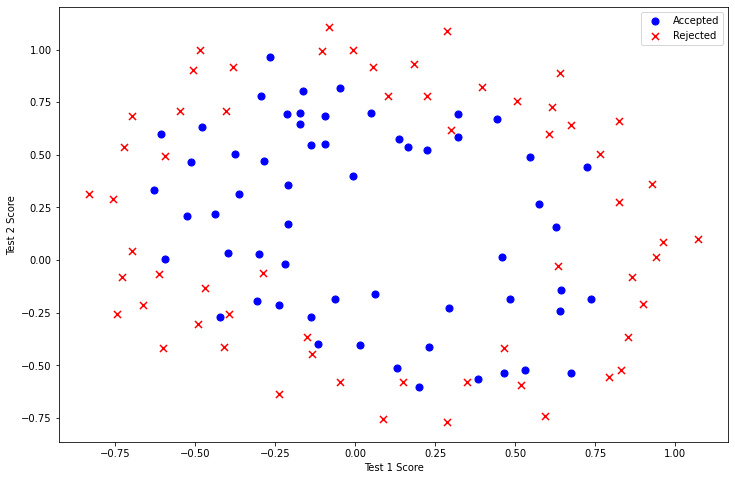

In [2]:
path = os.getcwd() + '\ex2data2.txt'  
data2 = pd.read_csv(path, header=None, names=['Test 1', 'Test 2', 'Accepted'])
data2_show = pd.read_csv(path, header=None, names=['Test 1', 'Test 2', 'Accepted'])

# plot the data
positive = data2[data2['Accepted'].isin([1])]  
negative = data2[data2['Accepted'].isin([0])]
fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter(positive['Test 1'], positive['Test 2'], s=50, c='b', marker='o', label='Accepted')  
ax.scatter(negative['Test 1'], negative['Test 2'], s=50, c='r', marker='x', label='Rejected')  
ax.legend()  
ax.set_xlabel('Test 1 Score')  
ax.set_ylabel('Test 2 Score')

# define hypothesis complexity
degree = 2              # degree of complexity
x1 = data2['Test 1']  
x2 = data2['Test 2']

# add a ones column - this makes the matrix multiplication work out easier
data2.insert(3, 'Ones', 1)

# generate extra features - powers and products of existing features x1 and x2
for i in range(1, degree):  
    for j in range(0, i):
        data2['F' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)

# lose the original features
data2.drop('Test 1', axis=1, inplace=True)  
data2.drop('Test 2', axis=1, inplace=True)

# set X and y (remember from above that we moved the label to column 0)
cols = data2.shape[1]  
X2 = data2.iloc[:,1:cols]  
y2 = data2.iloc[:,0:1]

print (data2_show)
print (data2)

### Split data into training and test subsets,
### choose regularization term Lambda and calculate prediction accuracy

In [3]:
# split the data into a training subset (70%) and a testing subset (30%)
from sklearn.model_selection import train_test_split
ts = 0.3
X2, X2_test, y2, y2_test = train_test_split(X2, y2, test_size = ts, random_state = 0)

# convert to numpy arrays and initalize the parameter array theta
X2 = np.array(X2.values)                # features of the training subset
y2 = np.array(y2.values)                # values of the training subset
X2_test = np.array(X2_test.values)      # features of the testing subset
y2_test = np.array(y2_test.values)      # values of the testing subset 

# the number of parameters theta is the sum of the first n integers + 1 (for theta0), 
# where n is the degree of hypothesis complexity
number_of_parameters = int(int((degree-1)**2+degree-1)/2+1)
theta2 = np.zeros(number_of_parameters)

RegTerm = 1000   # Lambda - the regularization term

# minimize the cost function and find the parameters theta, in the first element of result
import scipy.optimize as opt  
result2 = opt.fmin_tnc(func=costReg, x0=theta2, fprime=gradientReg, args=(X2, y2, RegTerm), disp=0)  
#print (result2)

# predict the classification given the parameters and compare it to the actual data values
theta_min = np.matrix(result2[0])  
predictions = predict(theta_min, X2_test)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y2_test)]
accuracy = sum(correct)*100/len(correct)
print ('accuracy = {0}%'.format(accuracy))

accuracy = 52.77777777777778%
